In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from IPython.display import Image
import pandas as pd
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

sns.set()

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames.
fname_train = "train.csv"
fname_test = "test.csv"

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    pass
else:
    dirname = "/kaggle/input/titanic/"
    fname_train = dirname + fname_train
    fname_test = dirname + fname_test

In [2]:
Image(url= "https://static1.squarespace.com/static/5006453fe4b09ef2252ba068/t/5090b249e4b047ba54dfd258/1351660113175/TItanic-Survival-Infographic.jpg?format=1500w")

# "What do we have here?"

In [3]:
titanic = pd.read_csv(fname_train)
titanic_orig = titanic
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#titanic = titanic.infer_objects()
titanic.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

## Fill missing values

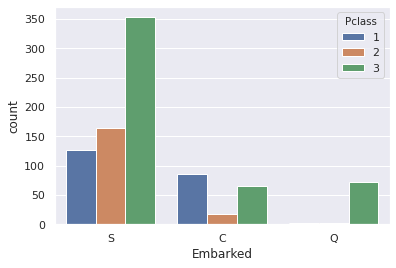

In [6]:
sns.countplot(titanic_orig.Embarked, hue=titanic.Pclass)

In [7]:
titanic_orig[titanic_orig.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
titanic.loc[61, "Embarked"] = "S"
titanic.loc[829, "Embarked"] = "S"

In [9]:
titanic[titanic.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [10]:
class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic_orig.index, columns=titanic_orig.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

# add_cabin_letter = Pipeline([
#     ("cabin_fill", SimpleImputer(strategy="most_frequent")),
#     ("add_cabin_letters", CabinLetterOnly())
# ])

add_cabin_letter = Pipeline([
    ("add_cabin_letters", CabinLetterOnly())
])

titanic = pd.DataFrame(add_cabin_letter.fit_transform(titanic_orig), index=titanic_orig.index,
                       columns = titanic_orig.columns.union(pd.Index(["Cabin_letter"]), sort=False))

In [11]:
len(titanic.Cabin[titanic.Cabin.notna()])

204

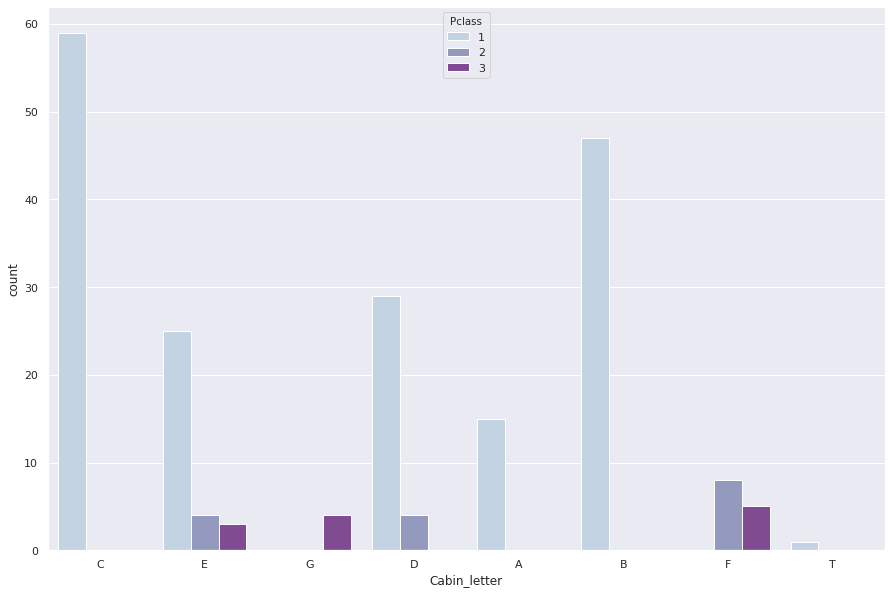

In [12]:
cl_notna = titanic[titanic.Cabin_letter.notna()]

fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.countplot(data=cl_notna, x="Cabin_letter", hue="Pclass", ax = ax, palette="BuPu")

In [13]:
titanic.loc[ (titanic.Pclass == 1) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'C'
titanic.loc[ (titanic.Pclass == 2) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'F'
titanic.loc[ (titanic.Pclass == 3) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'G'

titanic.drop("Cabin", axis=1, inplace=True)

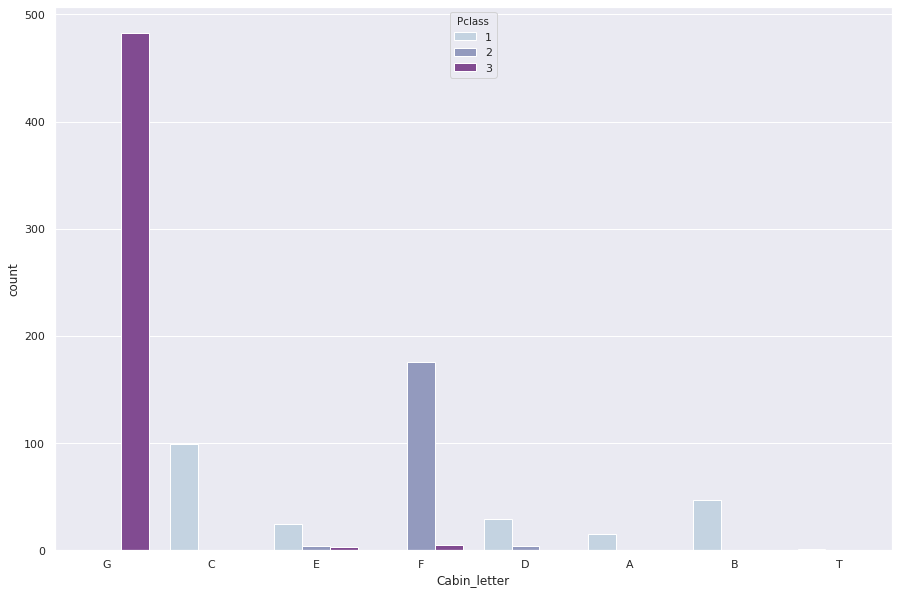

In [14]:
cl_notna = titanic[titanic.Cabin_letter.notna()]

fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.countplot(data=cl_notna, x="Cabin_letter", hue="Pclass", ax = ax, palette="BuPu")

In [15]:
titanic["Family_size"] = titanic_orig.SibSp + titanic_orig.Parch

In [16]:
s_ticket_group = titanic.groupby("Ticket").size().rename("Ticket_group_size")
titanic = titanic.join(s_ticket_group, on="Ticket", sort=False)

In [17]:
titanic.groupby("Ticket").size()

Ticket
110152         3
110413         3
110465         2
110564         1
110813         1
              ..
W./C. 6608     4
W./C. 6609     1
W.E.P. 5734    1
W/C 14208      1
WE/P 5735      2
Length: 681, dtype: int64

In [18]:
titanic["Fare_p_person"] = pd.Series(np.nan)
titanic.loc[titanic.Ticket_group_size == 1, "Fare_p_person"] = titanic.loc[titanic.Ticket_group_size == 1, "Fare"]
titanic.loc[(titanic.Ticket_group_size > 1), "Fare_p_person"] = \
    titanic.loc[(titanic.Ticket_group_size > 1), "Fare"] / (titanic.loc[(titanic.Ticket_group_size > 0), "Ticket_group_size"])

In [19]:
titanic.loc[titanic.Pclass == 3, "Fare_p_person"].quantile(0.95)

11.899999999999999

In [20]:
titanic.loc[titanic.Pclass == 2, "Fare_p_person"].quantile(0.95)

26.0

In [21]:
titanic.loc[titanic.Pclass == 1, "Fare_p_person"].quantile(0.1)

26.0

In [22]:
titanic.loc[titanic.Pclass == 1, "Fare_p_person"].max()

221.7792

In [23]:
age_round = titanic_orig.Age.dropna().apply(np.floor)
titanic = titanic.join(age_round, lsuffix="_x", sort=False)
titanic.drop("Age_x", axis=1, inplace=True)

In [24]:
knnimputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

mask = titanic.Age.notna() & ( (titanic.Fare_p_person < 12) | (titanic.Age < 12) )
df_children_or_low_fare = titanic.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_low_fare = titanic.loc[(titanic.Fare_p_person < 12) & titanic.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_low_fare)
titanic.loc[(titanic.Fare_p_person < 12) & titanic.Age.isna(), "Age"] = imp[:, 2]

mask = titanic.Age.notna() & (titanic.Fare_p_person >= 12)
df_children_or_low_fare = titanic.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_usual_fare = titanic.loc[(titanic.Fare_p_person >= 12) & titanic.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_usual_fare)
titanic.loc[(titanic.Fare_p_person >= 12) & titanic.Age.isna(), "Age"] = imp[:, 2]

In [25]:
# sex_pip = Pipeline([
#     ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
# ]
    
sex_pip = Pipeline([
    ('sex_label', LabelEncoder())
])

fare_pip = Pipeline([
    ("fare_mean", SimpleImputer(strategy="mean")),
    ('fare_std', StandardScaler())
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_pip = Pipeline([
    ('age_std', StandardScaler())
])

parch_pip = Pipeline([
    ('parch_std', StandardScaler())
])

sibsp_pip = Pipeline([
    ('sibsp_std', StandardScaler())
])

add_attrs = Pipeline([
    ("cabin_fill", SimpleImputer(strategy="most_frequent")),
    ("add_cabin_letters", CabinLetterOnly())
])

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

attr_pip = ColumnTransformer([
    #("passthrough", "passthrough", ["Pclass"]),
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"]),
    ("age", fare_pip, ["Age"]),
    ("parch", parch_pip, ["Parch"]),
    ("sibsp", sibsp_pip, ["SibSp"]),
    #("cabin_add", add_attrs, ["Cabin"]),
    #("cabin_trans", cabin_pip, ["Cabin_letter"]),
], remainder="drop")


### models ###

lin_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_reg', LinearRegression())
])

log_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('log_reg', LogisticRegression(multi_class="multinomial"))
])

sgd_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('sgd_clf', SGDClassifier(random_state=42))
])

dectree_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('dec_tree', DecisionTreeClassifier(random_state=42))
])

rndforest_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('rnd_forest', RandomForestClassifier(random_state=42))
])

lin_svc_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_svc', LinearSVC(C = 10, loss = "hinge"))
])

svc_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_svc', SVC(C = 10))
])

NameError: name 'LinearRegression' is not defined

# Create train and dev test sets now to avoid data snooping bias

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

## Stratify on Surived column for now. Maybe there is better.

In [ ]:
for train_ix, test_ix in split.split(titanic, titanic["Survived"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

strat_train = strat_train.infer_objects()
strat_devtest = strat_devtest.infer_objects()

# Inspect further

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (5,5))
sns.countplot(x="Survived", data=strat_train, ax = ax[0], palette = "RdGy")
sns.countplot(x="Survived", hue="Sex", data=strat_train, ax = ax[0], palette = "BuPu")
sns.countplot(x="Survived", data=strat_train, ax = ax[1], palette = "RdGy")
sns.countplot(x="Survived", hue="Pclass", data=strat_train, ax = ax[1], palette="cividis")

In [ ]:
strat_train["Fare_cat"] = pd.cut(strat_train.Fare_p_person, bins = [0, 13, 30, 222], include_lowest=True)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.countplot(data=strat_train, x = "Fare_cat", hue = "Survived", ax = ax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
strat_train["Age_cat"] = pd.cut(strat_train["Age"].astype(int), bins = 4)
sns.countplot(data=strat_train, x = "Age_cat", hue = "Survived", ax = ax)

In [ ]:
g = sns.FacetGrid(col="Sex", row="Pclass", data=strat_train)
g.map_dataframe(sns.countplot, "Survived")

In [ ]:
sns.countplot(strat_train.Embarked, hue=strat_train.Survived)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,15), subplot_kw={"projection" : "3d"})
sex_enc = LabelEncoder().fit_transform(strat_train["Sex"])
p = ax.scatter3D(xs = strat_train.index, ys=sex_enc, zs=strat_train.Pclass, c = strat_train.Survived,
                cmap = "viridis")
fig.colorbar(p)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,15), subplot_kw={"projection" : "3d"})
fare_cat_enc = LabelEncoder().fit_transform(strat_train["Fare_cat"]).astype(int)
p = ax.scatter3D(xs = strat_train.index, ys=sex_enc, zs=fare_cat_enc, c=strat_train["Survived"],
              cmap="viridis")
fig.colorbar(p)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
titanic["Age_cat"] = pd.cut(titanic["Age"].astype(int), bins = 4)
sns.countplot(data=titanic, x = "Age_cat", hue = "Survived", ax = ax)

# Labels

In [ ]:
# titanic_labels = titanic["Survived"].astype(int)
# strat_train_labels = strat_train["Survived"].astype(int)
# strat_devtest_labels = strat_devtest["Survived"].astype(int)
# strat_train.drop("Survived", inplace=True, axis=1)
# strat_devtest.drop("Survived", inplace=True, axis=1)

# Prepare test set

In [ ]:
test = pd.read_csv("test.csv")
test.info()